In [87]:
import os
import math
import pandas as pd

def calculate_h_index(quotation): #h_ndex
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    h_index = 0
    for i, quotation in enumerate(quotation):
        if quotation >= i + 1:
            h_index = i + 1
        else:
            break

    return h_index

def calculate_i10_index(quotation):  #i10_index
    i10_index = sum(1 for quotation in quotation if quotation >= 10)
    return i10_index

def calculate_g_index(quotation):  #g_index
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    g_index = 0
    quotation_sum=0
    for i, quotation in enumerate(quotation):
        quotation_sum+=quotation
        if quotation_sum >= (i + 1)**2:
            g_index = i + 1

    return g_index

#Object 타입에서 숫자형 체크용
def is_numeric(value):
    try:
        float(value)  # float으로 변환 가능한 경우 숫자
        return True
    except (ValueError, TypeError):
        return False

def recentness(pYears):
    # dt = datetime.datetime.now()#현재날짜
    dt = 2013
    rct = 0
    lct = 0
    if len(pYears) == 0:
        rct = 0
        lct = 0
    else:
        year_avg = sum(pYears) / len(pYears)
        if year_avg >= int(dt)-2: #int(dt.year)-2:
            lct = 1
        # else:
        #     lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)
        elif int(dt)-15 < year_avg <= int(dt)-3:
            lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)

        rct += len(pYears) #연도 개수

    return rct, lct

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [88]:
#authors.all 파일 위치 주소
authors_file_path = r"C:\Users\isjun\바탕 화면\연구실\전문가 검색\gsc_data\gsc_data\authors.all"

try:
    with open(authors_file_path, 'r', encoding='cp1252') as file:
        lines = file.read().splitlines()
        data = [line.split('|') for line in lines]
        columns = ["Valid", "Name", "Affiliation", "Email Domain", "Citation Count", "ID"]
        df_a = pd.DataFrame(data,columns=columns) # authors 의 a
        # df_a = df_a.drop(columns=["C6", "C7"])
        print("변환 완료")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다.")
except UnicodeDecodeError:
    print("파일을 ANSI(Windows-1252) 인코딩으로 열 수 없습니다.")
    
df_a_copy = df_a.copy()  # df_a의 복사본 생성

for index, row in df_a_copy.iterrows():
    if pd.isna(row[5]):  
        if pd.isna(row[4]):
            if pd.isna(row[3]):  # 1의 경우
                row[5] = row[2] 
            else:  # 2,3,4 의 경우
                row[5] = row[3]
                if is_numeric(row[2]): # 4의 경우
                    row[4] = row[2]
                    row[2] = None
                    row[3] = None
                elif '.' in str(row[2]):  # 3의 경우
                    row[3] = row[2]
                    row[2] = None
                    row[4] = None
                else: # 2의 경우
                    row[3] = None
        else:  # 5,6,7 의 경우
            row[5] = row[4] 
            if is_numeric(row[3]): # 6,7 의 경우
                row[4] = row[3]
                if '.' in str(row[2]): # 7 의 경우
                    row[3] = row[2]
                    row[2] = None
                else: # 6의 경우
                    
                    row[3] = None
            else: #5의 경우
                row[4] = None

변환 완료


In [89]:
#gsc_data\DATA 폴더 경로
folder_path = r"C:\Users\isjun\바탕 화면\연구실\전문가 검색\gsc_data\gsc_data\DATA"

max_scoquality = 62888.30906843457
max_rct = 15106

max_lct = []

# df_a_copy의 각 행에서 1번 열의 값을 추출
for index, row in df_a_copy.iterrows():
    name = row[5]  # 1번 열의 값
    
    # 파일 경로 생성
    file_path = os.path.join(folder_path, name + "_.dat")
    
    # 파일이 존재하는지 확인
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            # 파일의 각 줄을 읽어 리스트로 저장
            lines = file.readlines()

        # 각 줄을 나누어서 리스트로 저장
        line_lists = [line.strip().split('|') for line in lines]
        
        #빈 리스트 생성
        citations = [] #인용수
        years = [] #연도
        scoquality = 0 #품질
        for line_list in line_lists:
            if len(line_list) > 0:
                citations.append(int(line_list[0]))
                years.append(int(line_list[1]))
                scoquality += math.log(int(line_list[0]*1)+1)
        
        # print(name, years)
        rct, lct = recentness(years)
        # max_lct.append(rct)
        norm_scoquality = scoquality/max_scoquality
        # norm_recentness = rct/max_rct*0.66*lct
        norm_recentness = ((rct/max_rct)+lct)*0.66
        score = (norm_scoquality + norm_recentness)*50
        # print(rct, scoquality, scoquality/max_scoquality, rct/max_rct, lct, norm_recentness, score)
        #각 index 계산 후 df_a_copy에 새로운 열로 추가
        df_a_copy.at[index,"Paper Count"] = len(citations)
        df_a_copy.at[index,"h-index"] = calculate_h_index(citations)
        df_a_copy.at[index,"i10-index"] = calculate_i10_index(citations)
        df_a_copy.at[index,"g-index"] = calculate_g_index(citations)
        df_a_copy.at[index,"scoquality"] = norm_scoquality
        df_a_copy.at[index,"recentness"] = norm_recentness
        df_a_copy.at[index,"score"] = score
    
    else:
        print(f"파일을 찾을 수 없습니다: {file_path}")
        
df_a_copy['ID'] = 'id_' + df_a_copy['ID']

# print(df_a_copy)
df_a_copy.head(20)
df_a_copy.to_csv('output.csv', index=False)
df_a_copy.to_csv('output_index.csv', index=True)

In [90]:
import csv
import pandas as pd

# CSV 파일 경로
raw_data = 'output.csv'
df = pd.read_csv(raw_data)

#지수별로 내림차순 정렬
H_sorted=df.sort_values(by='h-index', ascending=False)
I10_sorted=df.sort_values(by='i10-index', ascending=False)
G_sorted=df.sort_values(by='g-index', ascending=False)
Citation_sorted=df.sort_values(by='Citation Count', ascending=False)
PaperC_sorted=df.sort_values(by='Paper Count', ascending=False)
scoquality_sorted=df.sort_values(by='scoquality', ascending=False)
recentness_sorted=df.sort_values(by='recentness', ascending=False)
score_sorted=df.sort_values(by='score', ascending=False)

#필요없는 컬럼 삭제
H_sorted=H_sorted.reset_index(drop=True, inplace=False)
I10_sorted=I10_sorted.reset_index(drop=True, inplace=False)
G_sorted=G_sorted.reset_index(drop=True, inplace=False)
Citation_sorted=Citation_sorted.reset_index(drop=True, inplace=False)
PaperC_sorted=PaperC_sorted.reset_index(drop=True, inplace=False)
scoquality_sorted=scoquality_sorted.reset_index(drop=True, inplace=False)
recentness_sorted=recentness_sorted.reset_index(drop=True, inplace=False)
score_sorted=score_sorted.reset_index(drop=True, inplace=False)

#지수 순위 입력
# num=int(input("숫자 입력 : "))
num=50

#해당 순위이내의 결과만 남김
H_sorted = H_sorted.head(num)
I10_sorted = I10_sorted.head(num)
G_sorted = G_sorted.head(num)
score_sorted = score_sorted.head(num)

Citation_sorted = Citation_sorted.head(num)
PaperC_sorted = PaperC_sorted.head(num)
scoquality_sorted = scoquality_sorted.head(num)
recentness_sorted = recentness_sorted.head(num)

#csv 파일 저장
# H_sorted.to_csv('H_sorted.csv')
# I10_sorted.to_csv('I10_sorted.csv')
# G_sorted.to_csv('G_sorted.csv')
# Citation_sorted.to_csv('Citation_sorted.csv')
# PaperC_sorted.to_csv('PaperC_sorted.csv')
# scoquality_sorted.to_csv('scoquality_sorted.csv')
# recentness_sorted.to_csv('recentness_sorted.csv')
# score_sorted.to_csv('score_sorted.csv')

score_sorted.drop(columns=['Valid', 'Affiliation', 'h-index', 'i10-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness'], axis=1, inplace=True)
H_sorted.drop(columns=['Valid', 'Affiliation', 'i10-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)
I10_sorted.drop(columns=['Valid','Affiliation', 'h-index', 'g-index', 'Citation Count','Email Domain', 'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)
G_sorted.drop(columns=['Valid','Affiliation', 'i10-index', 'h-index', 'Citation Count','Email Domain',  'Paper Count', 'scoquality', 'recentness','score'], axis=1, inplace=True)

score_sorted.columns=['name', 'score_ID', 'score']
H_sorted.columns=['name','ID','h_score']
I10_sorted.columns=['name','ID','i10_score']
G_sorted.columns=['name','ID','g_score']

score_sorted['rank'] = score_sorted['score'].rank(method='min', ascending=False).astype(int)
H_sorted['rank'] = H_sorted['h_score'].rank(method='min', ascending=False).astype(int)
I10_sorted['rank'] = I10_sorted['i10_score'].rank(method='min', ascending=False).astype(int)
G_sorted['rank'] = G_sorted['g_score'].rank(method='min', ascending=False).astype(int)



Combine=[ H_sorted, I10_sorted, G_sorted]
Combined_df=pd.concat(Combine, axis=1)

# print(Combined_df)
# name_count=Combined_df['Name'].value_counts()
# ID_count=Combined_df['ID'].value_counts()

# ID_count_df = pd.DataFrame({'ID': ID_count.index, 'Count': name_count.values})
# ID_count.to_csv('ID_count.csv')
# print(Combined_df)

print(Combined_df)

                        name               ID  h_score  rank                             name               ID  i10_score  rank                      name               ID  g_score  rank
0   Graham Colditz, MD, DrPH  id_M5_mEHQAAAAJ    213.0     1                       Jiming Liu  id_Il6ArO0AAAAJ     2187.0     1           Michel Foucault  id_AKqYlxMAAAAJ    524.0     1
1            Pierre Bourdieu  id_d_lp40IAAAAJ    180.0     2                 Anuj Kumar Singh  id_XSGHN8IAAAAJ     1506.0     2           Pierre Bourdieu  id_d_lp40IAAAAJ    501.0     2
2            Michel Foucault  id_AKqYlxMAAAAJ    163.0     3                        yanxi liu  id_9gpR5y0AAAAJ     1426.0     3             Herbert Simon  id_9d7rMrkAAAAJ    421.0     3
3                 Eric Topol  id_E2-uIQYAAAAJ    159.0     4                      Joseph Wang  id_0DEykT4AAAAJ     1253.0     4                 Max Weber  id_fT8j_PUAAAAJ    366.0     4
4              Eugene Koonin  id_F4P3ghEAAAAJ    144.0     5          

In [91]:
all_ranks = pd.concat([H_sorted, I10_sorted, G_sorted])

# 이름을 기준으로 등수 합계 계산
rank_sum = all_ranks.groupby('ID').sum().reset_index()

# 결과 출력
print(rank_sum)

                 ID                                               name  h_score  rank  i10_score  g_score
0   id_-zgxVEUAAAAJ                                      Boris Malomed      0.0    25      457.0      0.0
1   id_0A_lO2UAAAAJ      Jacques DerridaJacques DerridaJacques Derrida    125.0    32      662.0    302.0
2   id_0DEykT4AAAAJ                             Joseph WangJoseph Wang    106.0    33     1253.0      0.0
3   id_1fatN9EAAAAJ  H. Eugene StanleyH. Eugene StanleyH. Eugene St...    123.0    55      729.0    250.0
4   id_1sSj1fYAAAAJ                           Carlos FrenkCarlos Frenk    105.0    77        0.0    229.0
5   id_2Dd5uoIAAAAJ                                  Stanislas Dehaene     97.0    49        0.0      0.0
6   id_3PCz1j0AAAAJ                                          Tao Jiang      0.0    44      400.0      0.0
7   id_3d_DFCYAAAAJ                                  Michael Von Korff    110.0    23        0.0      0.0
8   id_4R7_wW8AAAAJ                           

In [92]:
for index, row in rank_sum.iterrows():
    if row['h_score']==0:
        rank_sum.loc[index, 'rank'] += 50
    if row['i10_score']==0:
        rank_sum.loc[index, 'rank'] += 50
    if row['g_score']==0:
        rank_sum.loc[index, 'rank'] += 50


rank_sum = rank_sum.sort_values(by='rank', ascending=True)
rank_sum=rank_sum.reset_index(drop=True, inplace=False)

print(rank_sum)

                 ID                                               name  h_score  rank  i10_score  g_score
0   id_M5_mEHQAAAAJ  Graham Colditz, MD, DrPHGraham Colditz, MD, Dr...    213.0    12      825.0    366.0
1   id_d_lp40IAAAAJ      Pierre BourdieuPierre BourdieuPierre Bourdieu    180.0    18      583.0    501.0
2   id_E2-uIQYAAAAJ                     Eric TopolEric TopolEric Topol    159.0    25      894.0    274.0
3   id_0A_lO2UAAAAJ      Jacques DerridaJacques DerridaJacques Derrida    125.0    32      662.0    302.0
4   id_I6dIhHQAAAAJ                        Karl MarxKarl MarxKarl Marx    125.0    33      621.0    307.0
5   id_AKqYlxMAAAAJ      Michel FoucaultMichel FoucaultMichel Foucault    163.0    34      441.0    524.0
6   id_F4P3ghEAAAAJ            Eugene KooninEugene KooninEugene Koonin    144.0    37      536.0    272.0
7   id_9d7rMrkAAAAJ            Herbert SimonHerbert SimonHerbert Simon    139.0    42      435.0    421.0
8   id_OU05Q_MAAAAJ            Guido KroemerGu

In [93]:
print(score_sorted)

                                                 name         score_ID      score  rank
0                                          Jiming Liu  id_Il6ArO0AAAAJ  60.442037     1
1                                    Anuj Kumar Singh  id_XSGHN8IAAAAJ  46.525831     2
2                                           yanxi liu  id_9gpR5y0AAAAJ  35.793382     3
3                                   Riccardo Di Sipio  id_FX5AyXoAAAAJ  33.468237     4
4                                    Alberto Graziano  id__wiSUCQAAAAJ  33.443852     5
5                                        Bora Isildak  id_hkN36w8AAAAJ  33.443659     6
6                                    Edward Karavakis  id_rb5oOIkAAAAJ  33.405690     7
7                                     taryana suryana  id_aeO4GvQAAAAJ  33.343697     8
8                                       Daniele Brida  id_AUhJBuwAAAAJ  33.269972     9
9                                   Julien Chevallier  id_dpWdU54AAAAJ  33.269918    10
10                              

In [100]:
#몇등까지 보실래요
rank=20 #사용자가 수정

score_list=score_sorted['score_ID'].values

answer_list=rank_sum['ID'].values

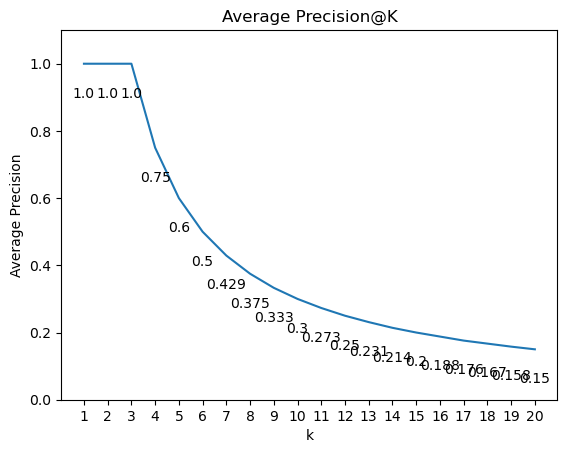

In [101]:
#Average precision@K
#k=rank 추천받을 사람 수
#rel=3개 지수가 만든 저자 목록에 전문가지수가 만든 저자가 포함 되어있다면 1, 아니라면 0
#m+사용자가 추천받은 것들 중 만족한 개수
import matplotlib.pyplot as plt

rel_list=score_list
rel_list = [1 if item in answer_list else 0 for item in score_list]
precision_list=[]
cnt_1=0
for k in range(rank):
    if rel_list[k]==1:
        cnt_1+=1

    precision_k=round(cnt_1/(k+1), 3)
    precision_list.append(precision_k)

k_list = list(range(1, rank + 1))

# 선 그래프 그리기
plt.plot(k_list, precision_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], precision_list[i] - 0.1, str(precision_list[i]), ha='center')

plt.xticks(range(1, 21))

# 그래프 제목 설정
plt.title("Average Precision@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("Average Precision")

# 그래프 보여주기
plt.show()


[10, 9, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[10, 19.0, 24.047438028571662, 24.047438028571662, 24.047438028571662, 24.047438028571662, 24.047438028571662, 24.047438028571662, 24.047438028571662, 24.047438028571662]
[10, 19.0, 24.047438028571662, 27.547438028571662, 30.13149737701202, 32.06576141318473, 33.49059016161682, 34.49059016161682, 35.12151991518828, 35.42254991085226]
[1.0, 1.0, 1.0, 0.873, 0.798, 0.75, 0.718, 0.697, 0.685, 0.679]
[1.0, 1.0, 1.0, 0.873, 0.798, 0.75, 0.718, 0.697, 0.685, 0.679]


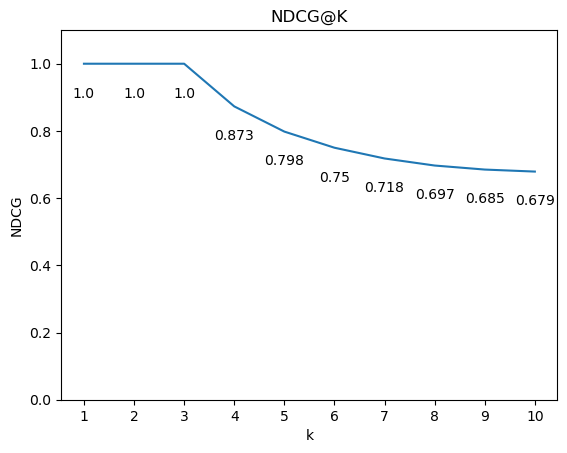

In [98]:
#NDCG@K
#NDCG=DCG/IDCG
import math

i=rank
rel_rank_list=[]
for item in score_list:
    if item in answer_list:
        rel_rank_list.append(i)  # 순위 추가
    else:
        rel_rank_list.append(0)  # 해당 항목이 answer_list에 없으면 0 추가
    i -= 1

print(rel_rank_list)

i=0
ideal_rel_rank_list = [i+1 for i in range(rank)]
ideal_rel_rank_list=ideal_rel_rank_list[::-1]
print(ideal_rel_rank_list)

DCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        DCG_list[k] = (rel_rank_list[k]/math.log2(k+1)) + DCG_list[k-1]
    else:
        DCG_list[k] = rel_rank_list[k]
print(DCG_list)


IDCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        IDCG_list[k] = (ideal_rel_rank_list[k]/math.log2(k+1)) + IDCG_list[k-1]
    else:
        IDCG_list[k] = ideal_rel_rank_list[k]

print(IDCG_list)
NDCG_list=[0] * rank
for k in range(rank):
    NDCG_list[k]=round(DCG_list[k]/IDCG_list[k],3)
print(NDCG_list)

k_list = list(range(1, rank + 1))
print(NDCG_list)
# 선 그래프 그리기
plt.plot(k_list, NDCG_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], NDCG_list[i] - 0.1, str(NDCG_list[i]), ha='center')

plt.xticks(range(1, 11))

# 그래프 제목 설정
plt.title("NDCG@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("NDCG")

# 그래프 보여주기
plt.show()
